# Overview

### 1. Dataset & Introduction

This dataset was collected from the Global Health Observatory (GHO) data repository under World Health Organization (WHO) from year 2000-2015. More information of the dataset can be found at:https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who

Our aim is predicting life expectancy (continous variable) by training a linear regression using several health factors (mortality factors, socioeconomical factors, etc.)

We will use nested cross-validation for hyperparameter tuning and model evaluation.

### 2. Main Steps We Will Follow

* Initialize regressors
* Set up the parameter grids
* Set up GridSearchCV for the hyperparameter tuning process of each algorithm. This takes place in the inner loop.
* Use cross_val_score to evaluate the best tuned model produced by GridSearchCV

The inner loop selects the best hyperparameter setting. The best hyperparameter will be evaluated on both the average across inner test folds and the one corresponding test fold of the outer loop.

***Example of nested cross-validation paradigm***
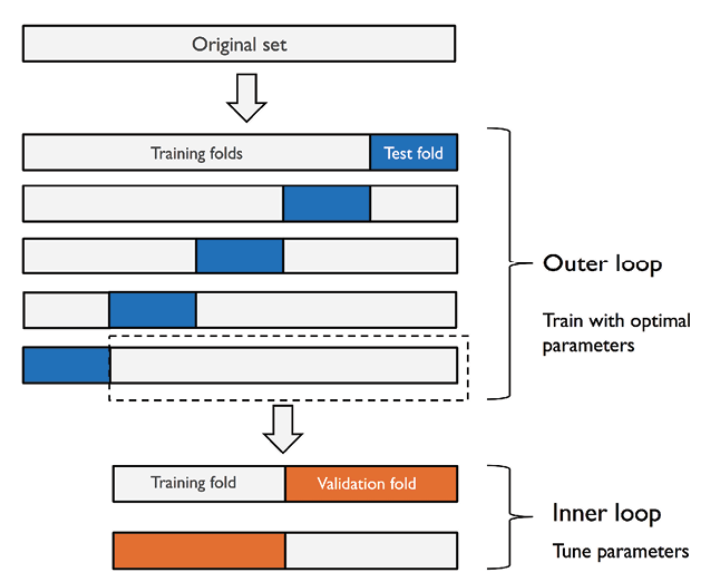


## Setting Up Our Environment

In [72]:
# Global Imports
import numpy as np   
import pandas as pd
import sklearn
import matplotlib.pyplot as plt   # plotting
from sklearn.model_selection import train_test_split  # ML data splits
from sklearn.preprocessing import MinMaxScaler # ML preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Import model
from sklearn.tree import DecisionTreeRegressor

# Import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## The data set

In [20]:
#Import dataset
df = pd.read_csv('C:/Users/kimng/Desktop/EDPY506/Code Presentation/Life Expectancy Data.csv')
df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


In [21]:
#check if there were any missing data
df.isnull().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

In [22]:
# drop missing data list-wise
df.dropna(inplace=True)

#reset index -- this is to replace old data index with index based on current data.
df = df.reset_index(drop=True)

# get new data dimension
df.shape 

(1649, 22)

After missing data deletion, the final dataset has 1649 instances and 22 columns. For simplicity, we will predict life expectancy from all columns except for 'Country' (number of predictors = 20). 'Status' will be recoded into binary value (0 = developing; 1= developed).

In [23]:
df.loc[df['Status'] == "Developing", 'Status'] = 0
df.loc[df['Status'] == "Developed", 'Status'] = 1
df['Status'] = df['Status'].apply(np.int64)

### Separate the features (X) and target (y)

In [24]:
df.columns # get list of column names

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

In [25]:
feature_names = ['Year', 'Status', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling']

target = ['Life expectancy ']

In [29]:
X = df[feature_names]
y = df[target]

## Initialize Regressor

In [94]:
model = DecisionTreeRegressor(random_state=42)

## Set up the parameter grids

In [81]:
param_grid = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
               'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
               }


## Set up GridSearchCV

In [95]:
search = GridSearchCV(estimator=model, 
                      param_grid = param_grid,
                      scoring = 'neg_mean_squared_error', #use MSE for model selection (larger neg-MSE = better model)
                      cv = 3, 
                      n_jobs = 1, 
                      refit = True)

##  Calculate the generalization error / accuracy

In [96]:
scores = cross_val_score(search, X_train, y_train, cv=5)

## Print the mean scores and standard deviation

In [97]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: -11.282 +/- 1.594


Nested Cross

In [99]:
# Empty list to store evaluation metrics
outer_scores_mae = []
outer_scores_mse = []
outer_scores_rmse = []
outer_scores_r2 = []

# configure the cross-validation procedure
outer_cv = StratifiedKFold(n_splits=5, shuffle=True) 

# Loop through each outer CV fold
for train_index_outer, val_index_outer in outer_cv.split(df, df.Status):
    train_set = df.loc[train_index_outer,:]
    val_set = df.loc[val_index_outer,:]

    feature_names = ['Year', 'Status', 'Adult Mortality',
                     'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
                     'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
                     'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
                     ' thinness  1-19 years', ' thinness 5-9 years',
                     'Income composition of resources', 'Schooling']
    target = ['Life expectancy ']

    X_train = train_set[feature_names]
    y_train = train_set[target]
    X_val = val_set[feature_names]
    y_val = val_set[target]
            
    #Apply grid search with CV=3 on outer train_set (this is hyperparameter tuning process within the inner loop)
    search.fit(X = X_train, y = y_train) # run inner loop hyperparam tuning
    print('\n        Best MSE (inner test folds):', (search.best_score_))
    print('        Best parameters:', search.best_params_)

    # Calculate evaluation metrics using best-tuned model on the outer val_set  
    #MSE
    y_val_hat = search.best_estimator_.predict(X_val)
    mse_val = mean_squared_error(y_val, y_val_hat)
    outer_scores_mse.append(mse_val)
    print('        MSE (on outer validation fold)', (outer_scores_mse[-1]))
    
    #MSE
    y_val_hat = search.best_estimator_.predict(X_val)
    rmse_val = np.sqrt(mse_val)
    outer_scores_rmse.append(rmse_val)
    print('        RMSE (on outer validation fold)', (outer_scores_rmse[-1]))

    # MAE
    mae_val = mean_absolute_error(y_val, y_val_hat)
    outer_scores_mae.append(mae_val)          
    print('        MAE (on outer validation fold)', (outer_scores_mae[-1]))
            
    # R2
    r2_val = r2_score(y_val, y_val_hat)
    outer_scores_r2.append(r2_val)    
    print('        R2 (on outer validation fold)', (outer_scores_r2[-1]))

# Print evaluation metrics across all outer loop folds
print('\n    Outer Loop:')
print('        MSE %.2f +/- %.2f'% (np.mean(outer_scores_mse), np.std(outer_scores_mse)))
print('        MSE %.2f +/- %.2f'% (np.mean(outer_scores_mse), np.std(outer_scores_mse)))
print('        MAE %.2f +/- %.2f'% (np.mean(outer_scores_mae), np.std(outer_scores_mae)))
print('        R2 %.2f +/- %.2f'% (np.mean(outer_scores_r2), np.std(outer_scores_r2)))


        Best MSE (inner test folds): -11.322892572920928
        Best parameters: {'max_depth': 6, 'min_samples_leaf': 6}
        MSE (on outer validation fold) 6.733296946205326
        RMSE (on outer validation fold) 2.594859716093594
        MAE (on outer validation fold) 1.81535219635742
        R2 (on outer validation fold) 0.910857973140579

        Best MSE (inner test folds): -11.54507472519171
        Best parameters: {'max_depth': 7, 'min_samples_leaf': 10}
        MSE (on outer validation fold) 4.986828888896995
        RMSE (on outer validation fold) 2.23312088541955
        MAE (on outer validation fold) 1.6005504923407874
        R2 (on outer validation fold) 0.9281139934386572

        Best MSE (inner test folds): -10.157266771599478
        Best parameters: {'max_depth': 7, 'min_samples_leaf': 7}
        MSE (on outer validation fold) 7.866136762211856
        RMSE (on outer validation fold) 2.804663395527502
        MAE (on outer validation fold) 2.0208269491231396
  